# Prueba
###  Generar un modelo matematico de prediccion para regresion lineal, exponencial, polinomico y logaritmico.

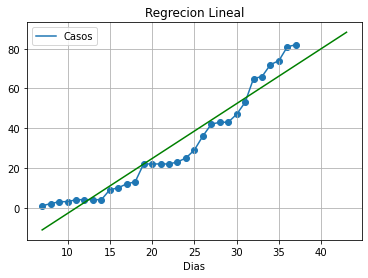

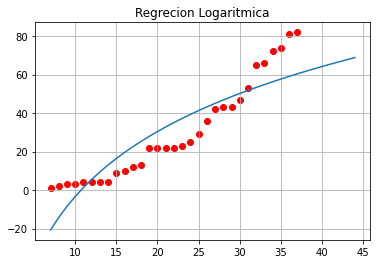

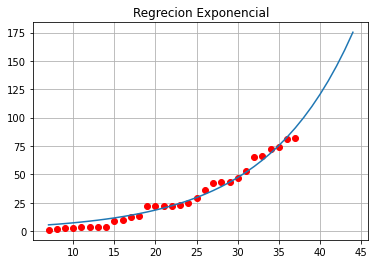

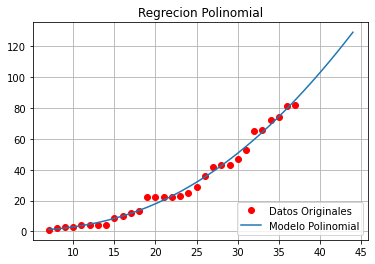

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

#lectura de los datos
df = pd.read_excel('Casos covid por provincias.xlsx')
df = pd.melt(df, id_vars=["Provincia"], var_name="Dias", value_name="Casos")
df = df[df['Provincia'].isin(['Tungurahua'])]
df = df[(df.Casos >= 1)]
df = df.loc[:,['Dias', 'Casos' ]]
FMT = '%d/%m/%Y'
date = df['Dias']
df['Dias'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("16/3/2020", FMT)).days)



df.plot(x ='Dias', y='Casos')

#Modelos Matematicos

#regrecion lineal
x = list(df.iloc [:, 0]) # Dias
y = list(df.iloc [:, 1]) # Casos 
regr = linear_model.LinearRegression()
regr.fit(np.array(x).reshape(-1, 1) ,y)
y_prediccion = regr.predict([[x[-1]+8]])

plt.scatter(x, y)
plt.title("Regrecion Lineal")
x_real = np.array(range(7, 44))
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.grid(True)
plt.show()

#modelo logistico
def mod_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(mod_logistico,x,y) #Extraemos los valores de los paramatros

pred_x = list(range(min(x),max(x)+8))

plt.scatter(x,y,label="Datos Reales",color="red")
plt.title("Regrecion Logaritmica")
plt.plot(pred_x, [mod_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.grid(True)
plt.show()

#modelo Exponencial
def mod_exponencial(x, a, b): #funcion que permite realizar la regrecion con el modelo exponencial
    return a * np.exp(b * x) 


popt, pcov = curve_fit(mod_exponencial, x, y, p0=(0,0.1))

pred_x = list(range(min(x),max(x)+8))
pred_x = np.array(pred_x, dtype=float)

plt.title("Regrecion Exponencial")
plt.plot(x, y, 'ro',label="Datos Originales")
plt.plot(pred_x,mod_exponencial(pred_x,*popt),label='Modelo Exponencial')
plt.grid(True)
plt.show()

#Modelo Polinomial
def func_polinomial(x, a, b, c, d):
    return a*x**4 + b*x**3 + c*x**2 + d*x + 1

popt1, pcov1 = curve_fit(func_polinomial, x, y)

pred_x1 = list(range(min(x),max(x)+7))

pred_x1 = np.array(pred_x1, dtype=float)

#grficamos los dos metodos para analizar

plt.title("Regrecion Polinomial")
plt.plot(x, y, 'ro',label="Datos Originales")
plt.plot(pred_x,func_polinomial(pred_x,*popt1),label='Modelo Polinomial')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



###  Calcular y generar el modelo SIR, con este dato obtener el betta y gamma.

 beta=0.4000, gamma=0.2305, R0=1.7357


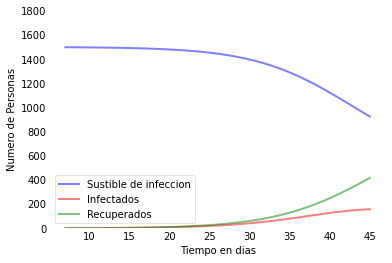

In [6]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

# los datos estan con una prdicion de una semana.

data = df

#Total de la poblacion se toma ese valor ya que la cantidad de infectados no pasa los 100
N = 1500
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = 0
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0

def errorCuadratico(point, data, S0, I0, R0):

    size = len(data)
    beta, gamma = point

    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
    
    solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

optimo = minimize(
            errorCuadratico,
            [0.001, 0.001],
            args=(data.Casos, S0, I0, R0),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )

beta, gamma = optimo.x

print(f" beta={beta:.4f}, gamma={gamma:.4f}, R0={beta/gamma:.4f}")



x3 = list(data.iloc [:, 0])

#cuadro de proyeccion a una semana 
t = np.linspace(x3[0], x3[-1]+8)
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.grid(True)
plt.show()

### Tomar la tasa de repoduccion efectiva que se calcula como:  


**Re** = R0 x N

In [7]:
#calculamos el Re:

re = 1.7357 * N
print(re)

2603.55


### Con el Re obtenido realizar la simulacion epidimiologica y su grado de difusion, para  obtener el numero de muertos, recuperados e infectados.

In [1]:
from random import randrange
import pygame


#Parametros de inicio
PROBA_MUERTE = 6.2  # Probabilidad de que la gente muera COVID
CONTAGION_RATE = 1.7357  # Factor R0 para la simulacion COVID probabilidad
PROBA_INFECT = CONTAGION_RATE * 10
PROBA_VACU = 0 # Probabilidad de que exista una vacuna, COVID = 0
SIMULACION_SPEED = 50 # Tiempo de un dia en milisegundos
nb_rows = 50 #Numero de filas
nb_cols = 50 #Numero de columnas

global display, myfont, states, states_temp

WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 247, 0)
BLACK = (0, 0, 0)

def get_vecinos(x, y):
    incx = randrange(3)
    incy = randrange(3)
    incx = (incx * 1) - 1
    incy = (incy * 1) - 1
    x2 = x + incx
    y2 = y + incy
    if x2 < 0:
        x2 = 0
    if x2 >= nb_cols:
        x2 = nb_cols - 1
    if y2 < 0:
        y2 = 0
    if y2 >= nb_rows:
        y2 = nb_rows - 1
    return [x2, y2]

def vacunar():
    for x in range(nb_cols):
        for y in range(nb_rows):
            if randrange(99) < PROBA_VACU:
                states[x][y] = 1

def contar_muertes():
    contador = 0
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == -1:
                contador +=  1
    return contador

#Definimos datos de inicio
states = [[0] * nb_cols for i1 in range(nb_rows)]
states_temp = [[0] * nb_cols for i1 in range(nb_rows)]
states_temp = states.copy()
states[25][25] = 10
it = 0 # Iteraciones
total_muerte = 0
infectados = 0
vacunar()


pygame.init()
pygame.font.init()
display=pygame.display.set_mode((800,750),0,32)
pygame.display.set_caption("Simulacion de Epidemia Covid-19 Ecuador-Tungurahua")
font=pygame.font.SysFont('Calibri', 30)
display.fill(WHITE)

while True:
    pygame.time.delay(SIMULACION_SPEED)
    it = it + 1
    if it <= 10000 and it >= 2:
        states_temp = states.copy()
        for x in range(nb_cols):
            for y in range(nb_rows):
                state = states[x][y]
                if state == -1:
                    pass
                if state >= 10:
                    states_temp[x][y] = state + 1
                if state >= 20:
                    if randrange(99) < PROBA_MUERTE:
                        states_temp[x][y] = -1
                    else:
                        states_temp[x][y] = 1
                if state >= 10 and state <= 20:
                    if randrange(99) < PROBA_INFECT:
                        neighbour = get_vecinos(x, y)
                        x2 = neighbour[0]
                        y2 = neighbour[1]
                        neigh_state = states[x2][y2]
                        if neigh_state == 0:
                            states_temp[x2][y2] = 10
        states = states_temp.copy()
        total_muerte = contar_muertes()
        
      
    pygame.draw.rect(display, WHITE, (250, 30, 260, 50))
    textsurface = font.render("Total Muertes: "+ str(total_muerte), False, (0,0,0))
    
    
    #display.blit(textsurface1, (30, 30))
    display.blit(textsurface, (150, 30))
    

    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == 0:
                color = BLUE
            if states[x][y] == 1:
                color = GREEN
            if states[x][y] >= 10:
                color = (states[x][y] * 12, 50, 50)
                infectados += 1
            if states[x][y] == -1:
                color = BLACK
            pygame.draw.circle(display, color, (100 + x * 12 + 5, 100 + y * 12 + 5), 5)
            pygame.draw.rect(display, WHITE, (100 + x * 12 + 3, 100 + y * 12 + 4, 1, 1))

    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
            pygame.quit()
            print("Total Infectados ", infectados)
        if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
            #Reiniciamos valores
            states = [[0] * nb_cols for i1 in range(nb_rows)]
            states_temp = [[0] * nb_cols for i1 in range(nb_rows)]
            states_temp = states.copy()
            states[50][50] = 10
            it = 0
            total_muerte = 0
            vacunar()
            
    pygame.display.update()


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Total Infectados  869


error: video system not initialized

### Captura de la Simulacion epidimiologica  

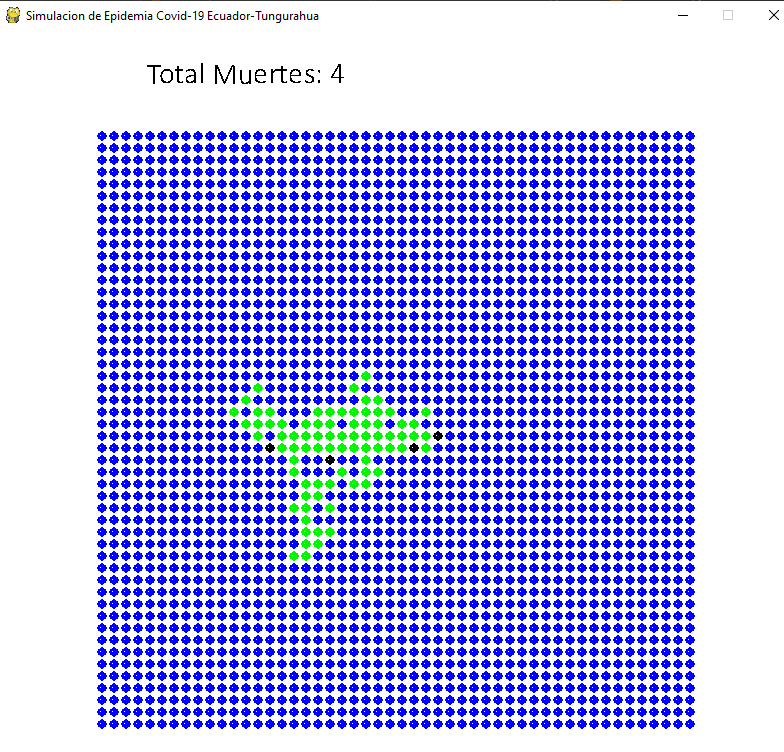

### Cual tiene una mejor prediccion  

El modelo que nos permite predecir de mejor forma es el Polinomico ya que se apega mas a los datos mediante la regrecion.  
Lo que nos permite tener un valor de de prediccion mas exacto y apegado a los datos proporcionados.  

### Ventajas y desventajas de los modelos.  
Las ventajas que nos brindan los diferentes modelos es que mediante la regresion y prediccion  se puede apreciar de manera muy  facil como la infeccion del covid19 evoluciona, otra ventaja es que con la ayuda de las librerias que ofrese python es facil implementar estos modelos de prediccion.  

La desventaja que se presentan con estos modelos es que si los datos que se les proporcionan no se apegan a la realidad  la solucion obtenida se aparta a los sucesos reales, alterando a si el analicis de la informacion.
